In [42]:
# disable any potential warning

import warnings
warnings.filterwarnings('ignore')

# 1. Setup the dosing_rl_gym environment
- Step1: copy the source files of the env 
```bash
git clone https://github.com/strongio/dosing-rl-gym
```

- Step2: install the package
```bash
cd dosing-rl-gym
python setup.py install
```

- Basic background of the environment is shown in this [jupyter](https://github.com/strongio/dosing-rl-gym/blob/master/dosing_rl_gym/resources/Diabetic%20Background.ipynb)

In [43]:
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

# set up the env
import gym
import dosing_rl_gym

# move the model to GPU for training.
# if you do not have GPU, set "cpu"
device = torch.device("cuda:1")

# 2. Create diabete-v0 simulator

In [55]:
env = gym.make("Diabetic-v0")

# insulin pump every 10 minutes in 1 day (144 steps)
episode_length = 10
env.set_episode_length(episode_length)

In [56]:
# A is the action space, representing insulin pump volumn (mU/min)
A = np.linspace(2, 3, 11)
A

array([2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ])

### action space is represented by:
- 0 Blood Glucose (mg/dL)
- 1 Remote Insulin (micro-u/ml)
- 2 Plasma Insulin (micro-u/ml)
- 3 S1
- 4 S2
- 5 Gut blood glucose (mg/dl)
- 6 Meal disturbance (mmol/L-min)
- 7 Previous Blood glucose (mg/dL)
- 8 Previous meal disturbance (mmol/L-min)

### reward is calculated by this function (dependent on the Glucose level)

Text(0, 0.5, 'Reward')

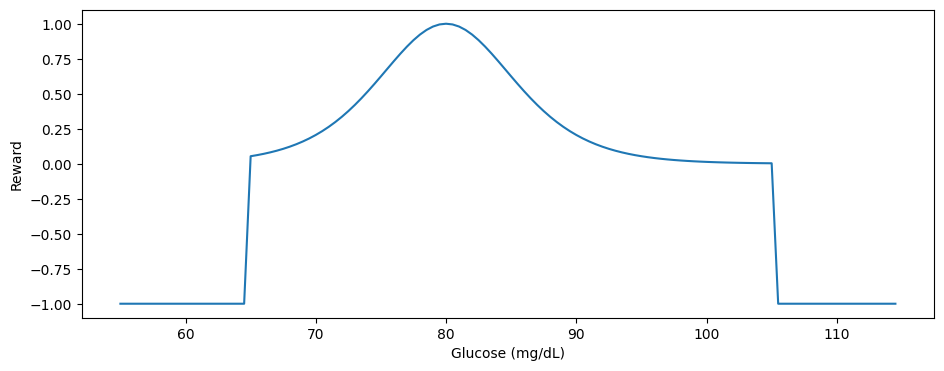

In [120]:
g = 0.7
target= 80.0
lb, ub = 65.0, 105.0
reward_func = []
dr = np.arange(55.0, 115.0, .5)
for v in dr:
    r = 1. - np.tanh(np.abs((v - target) / g) * .1) ** 2
    if (v < lb) or (v > ub):
        r = -1.
    reward_func.append(r)
    
plt.figure(1, figsize=(11,4))
plt.plot(dr, reward_func)
plt.xlabel('Glucose (mg/dL)')
plt.ylabel('Reward')

In [72]:
""" Example """

# the initial state of env is randomly initialized
env.reset()

# action
a = [2.5]

# next state
state, reward, done, _ = env.step([a])

print ("state", state)
print ("reward", reward)
print ("whether the game is over:", done)

state [  82.74149883   30.59912634   28.95833456   14.40160571   15.62373179
  254.08005318 1000.           82.46919802 1000.        ]
reward 0.8610384168897757
whether the game is over: False


# 3. collect offline RL samples from this env

In [63]:
# collect 2000 trajectories
n_episodes = 2000

samples = []
for e in tqdm(range(n_episodes)):
    env.reset()
    # after the first step (a=2.5), we start the game
    state, _, _, _ = env.step([2.5])
    
    for _ in range(env.episode_length-3):
        # randomly choose the action
        action = np.random.choice(A)
        state_, reward, _, _ = env.step([action])
        
        # get the (s, a, r, s') sample
        samples.append([state, action, reward, state_])
        state = state_
  
# split the S, A, R, S_ to separate variables
train_S = torch.FloatTensor([item[0] for item in samples])
train_A = torch.FloatTensor([item[1] for item in samples]).unsqueeze(-1)
train_R = torch.FloatTensor([item[2] for item in samples])
train_S_ = torch.FloatTensor([item[3] for item in samples])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:38<00:00, 20.40it/s]


In [64]:
# normalize the data

S_mean = train_S.mean(0)
S_std = train_S.std(0)

norm_train_S = (train_S - S_mean) / (S_std + 1e-8)
norm_train_A = (train_A - train_A.mean(0)) / (train_A.std(0) + 1e-8)
norm_train_S_ = (train_S_ - S_mean) / (S_std + 1e-8)

norm_train_S = norm_train_S.to(device)
norm_train_A = norm_train_A.to(device)
norm_train_S_ = norm_train_S_.to(device)

# no need to normalize the reward
train_R = train_R.to(device)

In [65]:
norm_train_S.shape, norm_train_A.shape, train_R.shape, norm_train_S_.shape

(torch.Size([284000, 9]),
 torch.Size([284000, 1]),
 torch.Size([284000]),
 torch.Size([284000, 9]))

# 4. build the DQN model

In [99]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 9 + 1 state with action input
        self.embedding = nn.Linear(10, 32)
        self.Q = nn.Sequential(
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
#             nn.Sigmoid(),
        )
    
    def forward(self, s, a):
        x = torch.cat([s, a], dim=-1)
        x = self.embedding(x)
        x = self.Q(torch.relu(x))
        return x
    
model = DQN()
model.to(device)

DQN(
  (embedding): Linear(in_features=10, out_features=32, bias=True)
  (Q): Sequential(
    (0): Linear(in_features=32, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [100]:
def evaluate(model, env):
    """ evaluate func the cumulative reward in the env using the model """
    ones = torch.ones(1, 1).to(device)
    
    # we evaluate after the first step with action a=2.5
    s, reward, done, _ = env.step([2.5])

    reward_list = []
    for _ in range(env.episode_length-3):
        s = torch.FloatTensor(s).unsqueeze(0).to(device)
        s = (s - S_mean.to(device)) / (S_std.to(device) + 1e-8)
        
        # select the best action from our model
        with torch.no_grad():
            response = []
            for a in A:
                response.append(model(s, ones * a).cpu().numpy())
        action = A[np.argmax(response)]
        
        s, reward, done, _ = env.step([action])
        reward_list.append(reward)
    return sum(reward_list)

env.reset()
env_copy = copy.deepcopy(env)

# evaluate on the initial model
evaluate(model, env_copy)

35.46531730656499

# 5. training the DQN model

In [101]:
alpha = 0.5
gamma = 0.95

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

model.train()

loss_curve = []
for epoch in range(5001):
    pre = model(norm_train_S, norm_train_A)
    
    # target Q(s, a)
    with torch.no_grad():
        max_part = []
        for a in A:
            max_part.append(model(norm_train_S_, torch.ones_like(norm_train_A) * a))
            
        max_part = torch.stack(max_part).squeeze(-1)
        max_part, _ = torch.max(max_part, 0, keepdim=True)
        target = pre + alpha * (train_R.unsqueeze(1) + gamma * max_part.T - pre)

#     print (pre.shape, target.shape)
    loss = criterion(pre, target)
    loss_curve.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        env_copy = copy.deepcopy(env)
        reward = evaluate(model, env_copy)
        print (f"--- epoch: {epoch} ---, trainig loss: {loss_curve[-1]}, reward: {reward}")

--- epoch: 0 ---, trainig loss: 0.05908508226275444, reward: 35.52270950886288
--- epoch: 500 ---, trainig loss: 0.06377474963665009, reward: 89.09879224441977
--- epoch: 1000 ---, trainig loss: 0.06710536032915115, reward: 89.09879224441977
--- epoch: 1500 ---, trainig loss: 0.06569214910268784, reward: 89.09879224441977
--- epoch: 2000 ---, trainig loss: 0.06342136859893799, reward: 89.09879224441977
--- epoch: 2500 ---, trainig loss: 0.06176581606268883, reward: 89.09879224441977
--- epoch: 3000 ---, trainig loss: 0.06124673783779144, reward: 89.09879224441977
--- epoch: 3500 ---, trainig loss: 0.06126878783106804, reward: 89.06626350407569
--- epoch: 4000 ---, trainig loss: 0.06128304451704025, reward: 89.01832894195431
--- epoch: 4500 ---, trainig loss: 0.061310891062021255, reward: 89.10066481001694
--- epoch: 5000 ---, trainig loss: 0.061429426074028015, reward: 87.61831571593262


# 6. visualize the performance

In [132]:
# let us evaluate the final model

ones = torch.ones(1, 1).to(device)
    
# we evaluate after the first step with action a=2.5
s, reward, done, _ = env.step([2.5])

reward_list = []
for _ in range(env.episode_length-3):
    s = torch.FloatTensor(s).unsqueeze(0).to(device)
    s = (s - S_mean.to(device)) / (S_std.to(device) + 1e-8)

    # select the best action from our model
    with torch.no_grad():
        response = []
        for a in A:
            response.append(model(s, ones * a).cpu().numpy())
    action = A[np.argmax(response)]

    s, reward, done, _ = env.step([action])
    reward_list.append(reward)

## 6.1 insulin pump over the day

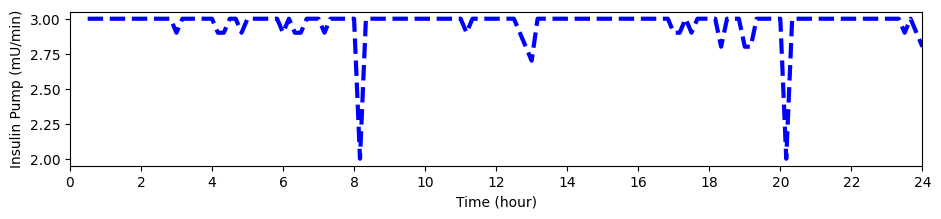

In [142]:
# Plot the results
plt.figure(1, figsize=(11,2))
ticks = np.linspace(0,24,13)

plt.plot(env.t[3:], env.u[3:], 'b--', linewidth=3)
plt.ylabel('Insulin Pump (mU/min)')
plt.xlim([0,24])
plt.xticks(ticks)
plt.xlabel('Time (hour)')
print ()

## 6.2 Glucose curve over the day

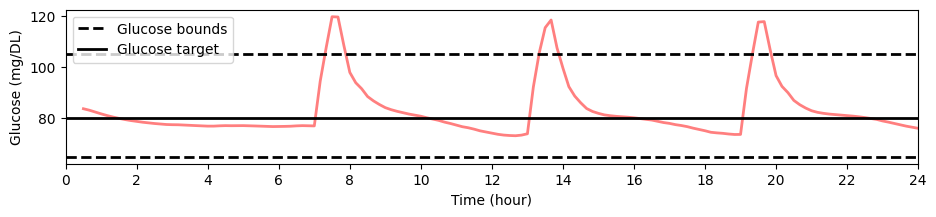

In [143]:
plt.figure(1, figsize=(11,2))
ticks = np.linspace(0,24,13)

plt.plot(env.t[3:], env.G[3:], 'r-',linewidth=2, alpha=0.5)
plt.plot([0,24],[105,105],'k--',linewidth=2,label='Glucose bounds')
plt.plot([0,24],[80,80],'k-',linewidth=2,label='Glucose target')
plt.plot([0,24],[65,65],'k--',linewidth=2)

plt.legend(loc='best')
plt.ylabel('Glucose (mg/DL)')
plt.xlim([0,24])
plt.xticks(ticks)
plt.xlabel('Time (hour)')
print ()

## 6.3 Reward curve over the day

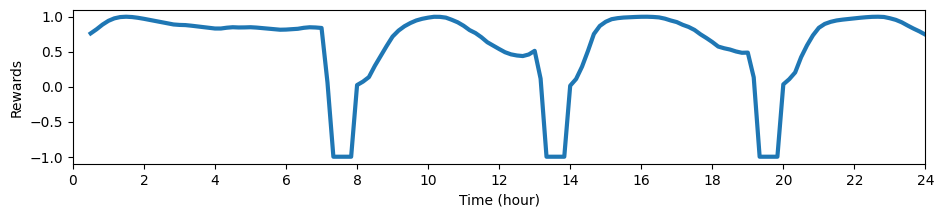

In [145]:
# Plot the results
plt.figure(1, figsize=(11,2))
ticks = np.linspace(0,24,13)

plt.plot(env.t[3:], reward_list, linewidth=3)
plt.ylabel('Rewards')
plt.xlim([0,24])
plt.xticks(ticks)
plt.xlabel('Time (hour)')
print ()

In [129]:
len(reward_list)

142